In [1]:
import matplotlib.pyplot as plt
import numpy as np
import os
import PIL
import tensorflow as tf
import cv2 as cv

from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential

import pathlib
import random

2124


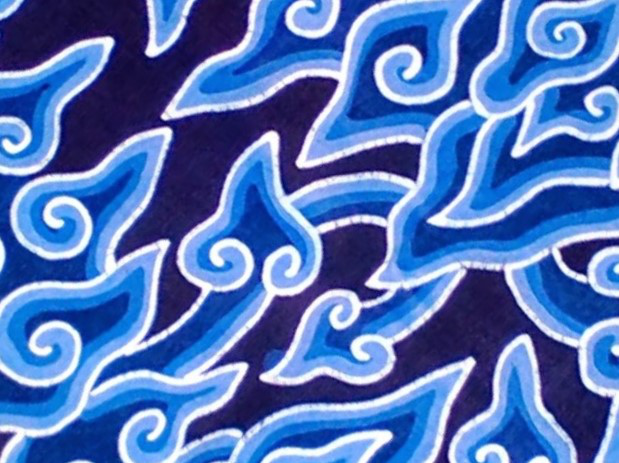

In [2]:
# -- Dataset path --

data_dir = pathlib.Path('Pictures\Batik Dataset Custom Sobel')

image_count = len(list(data_dir.glob('*/*.jpg')))
print(image_count)

motif = list(data_dir.glob('Megamendung/*'))
PIL.Image.open(str(motif[2]))

In [3]:
# -- Create Dataset --

batch_size = 35
img_height = 240
img_width = 240

# -- Split data for training & validation 80:20 --

train_ds = tf.keras.utils.image_dataset_from_directory(
  data_dir,
  validation_split=0.2,
  subset="training",
  seed=123,
  image_size=(img_height, img_width),
  batch_size=64)

val_ds = tf.keras.utils.image_dataset_from_directory(
  data_dir,
  validation_split=0.2,
  subset="validation",
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size)

class_names = train_ds.class_names
print(class_names)

Found 2212 files belonging to 4 classes.
Using 1770 files for training.
Found 2212 files belonging to 4 classes.
Using 442 files for validation.
['Kawung', 'Megamendung', 'Merak Ngibing', 'Parang']


In [4]:
# -- Configure dataset performance by keeping images in memory after loaded --

AUTOTUNE = tf.data.AUTOTUNE

train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)

In [5]:
# ----------------- CUSTOM AUGMENTATION -----------------

class RandomInvert(layers.Layer):
    def __init__(self, **kwargs):
      super().__init__(**kwargs)

    def call(self, x):
      p = 0.5
      if  tf.random.uniform([]) < p: x = (255-x)
      else: x
      return x

class RandomSaturation(layers.Layer):
    def __init__(self, **kwargs):
      super().__init__(**kwargs)
        
    def call(self, images):
      seeds = (random.randrange(1, 10), 1)
      images = tf.image.stateless_random_saturation(images, .1, 5, seeds)
      return images

class RandomHue(layers.Layer):
    def __init__(self, **kwargs):
      super().__init__(**kwargs)
        
    def call(self, images):
      seeds = (random.randrange(1, 10), 1)
      images = tf.image.stateless_random_hue(images, .35, seeds)
      return images

class RandomBrightness(layers.Layer):
    def __init__(self, **kwargs):
      super().__init__(**kwargs)
        
    def call(self, images):
      seeds = (random.randrange(1, 10), 1)
      images = tf.image.stateless_random_brightness(images, 0.4, seeds)
      return images

class RandomContrast(layers.Layer):
    def __init__(self, **kwargs):
      super().__init__(**kwargs)
        
    def call(self, images):
      seeds = (3, 1)
      images = tf.image.stateless_random_contrast(images, lower=.1, upper=1, seed=seeds)
      return images

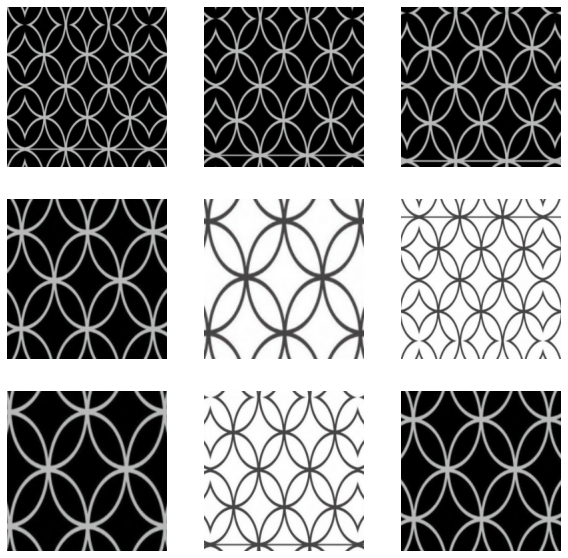

In [6]:
# -- data augmentation --

data_augmentation = keras.Sequential(
  [
    layers.RandomFlip("horizontal_and_vertical", input_shape=(img_height,img_width,3)),
#     layers.RandomRotation(.1),
    layers.RandomZoom(.3),
    RandomInvert(),
#     RandomContrast(),
#     RandomBrightness(),
#     RandomHue(),
#     RandomSaturation(),
  ]
)

# visualize
plt.figure(figsize=(10, 10))
for images, _ in train_ds.take(1):
  for i in range(9):
    augmented_images = data_augmentation(images)
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(augmented_images[0].numpy().astype("uint8"))
    plt.axis("off")

In [40]:
# -- Create Model --

num_classes = len(class_names)

model = Sequential([
  data_augmentation,
  layers.Rescaling(1./255, input_shape=(img_height, img_width, 3)),
  layers.Conv2D(16, 3, padding='same', activation='relu', dilation_rate=1),
  layers.MaxPooling2D(),
  layers.Conv2D(32, 3, padding='same', activation='relu', dilation_rate=2),
  layers.MaxPooling2D(),
  layers.Conv2D(64, 3, padding='same', activation='relu', dilation_rate=3),
  layers.MaxPooling2D(),
  layers.Dropout(.66),
  layers.Flatten(),
  layers.Dense(128, activation='relu'),
  layers.Dense(num_classes)
])

# -- Compile the Model --

model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])



In [41]:
epochs=100
history = model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs
)

Epoch 1/100
28/28 [==============================] - 22s 634ms/step - loss: 1.6384 - accuracy: 0.3147 - val_loss: 1.3641 - val_accuracy: 0.3213
Epoch 2/100
28/28 [==============================] - 5s 169ms/step - loss: 1.3249 - accuracy: 0.3870 - val_loss: 1.3320 - val_accuracy: 0.3778
Epoch 3/100
28/28 [==============================] - 5s 167ms/step - loss: 1.3274 - accuracy: 0.3678 - val_loss: 1.3102 - val_accuracy: 0.3959
Epoch 4/100
28/28 [==============================] - 5s 167ms/step - loss: 1.2830 - accuracy: 0.4220 - val_loss: 1.2983 - val_accuracy: 0.4299
Epoch 5/100
28/28 [==============================] - 5s 170ms/step - loss: 1.2994 - accuracy: 0.3972 - val_loss: 1.2420 - val_accuracy: 0.4638
Epoch 6/100
28/28 [==============================] - 5s 171ms/step - loss: 1.2937 - accuracy: 0.3915 - val_loss: 1.3383 - val_accuracy: 0.3914
Epoch 7/100
28/28 [==============================] - 5s 169ms/step - loss: 1.3046 - accuracy: 0.3955 - val_loss: 1.3515 - val_accuracy: 0.375

Epoch 58/100
28/28 [==============================] - 5s 169ms/step - loss: 0.2986 - accuracy: 0.8876 - val_loss: 0.2701 - val_accuracy: 0.8959
Epoch 59/100
28/28 [==============================] - 5s 168ms/step - loss: 0.2531 - accuracy: 0.9062 - val_loss: 0.4225 - val_accuracy: 0.8507
Epoch 60/100
28/28 [==============================] - 5s 170ms/step - loss: 0.2789 - accuracy: 0.8983 - val_loss: 0.2860 - val_accuracy: 0.9072
Epoch 61/100
28/28 [==============================] - 5s 168ms/step - loss: 0.2312 - accuracy: 0.9175 - val_loss: 0.3102 - val_accuracy: 0.8891
Epoch 62/100
28/28 [==============================] - 5s 168ms/step - loss: 0.2412 - accuracy: 0.9220 - val_loss: 0.3064 - val_accuracy: 0.9050
Epoch 63/100
28/28 [==============================] - 5s 168ms/step - loss: 0.2523 - accuracy: 0.9130 - val_loss: 0.2875 - val_accuracy: 0.9050
Epoch 64/100
28/28 [==============================] - 5s 171ms/step - loss: 0.2507 - accuracy: 0.9102 - val_loss: 0.3403 - val_accuracy:

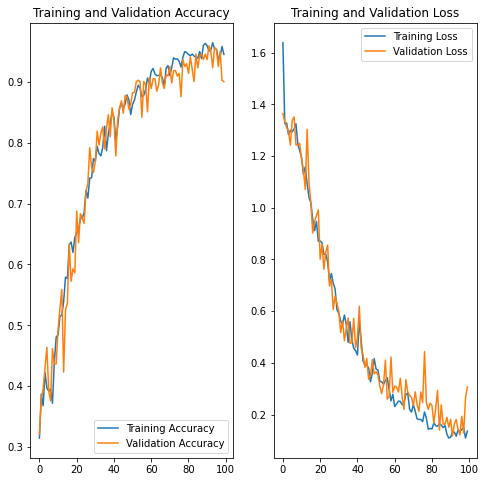

In [42]:
# -- Training Result --

acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

In [55]:
img = tf.keras.utils.load_img("Pictures\Testing Data\Kawung\_3S.jpg", target_size=(img_height, img_width))
img_array = tf.keras.utils.img_to_array(img)
img_array = tf.expand_dims(img_array, 0)     # Create a batch

predictions = model.predict(img_array)
score = tf.nn.softmax(predictions[0])
preds = tf.math.argmax(predictions, -1)

print(
  "This image most likely belongs to {} with a {:.2f} percent confidence."
  .format(class_names[np.argmax(score)], 100 * np.max(score))
)

This image most likely belongs to Kawung with a 94.94 percent confidence.
